# Was ist ein CNN-Modell und wie funktioniert es? 
 
Ein **Convolutional Neural Network (CNN)** ist ein spezieller Typ von künstlichem neuronalen Netzwerk, der besonders gut für die Verarbeitung von Daten mit einer Gitterstruktur geeignet ist – zum Beispiel Bilder (2D-Gitter) oder Zeitreihen (1D-Gitter). Im Gegensatz zu klassischen vollvernetzten Netzwerken nutzt ein CNN sogenannte Faltungsschichten (Convolutional Layers), die lokale Muster in den Daten erkennen können. Das macht CNNs sehr leistungsfähig für Aufgaben wie Bild- oder Signalverarbeitung.
 
## Unsere Modellarchitektur
 
```python
 class CNN(nn.Module):
     def __init__(self, in_channels, out_channels, kernel_size, num_classes):
         super().__init__()
         self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
         self.pool = nn.AdaptiveAvgPool1d(1)
         self.fc = nn.Linear(out_channels, num_classes)
 
     def forward(self, x):
         x = self.conv(x)
         x = self.pool(x).squeeze(-1)
         x = self.fc(x)
         return x
```
 
**Erklärung der Architektur:**
- Die erste Schicht ist eine 1D-Faltungsschicht (`nn.Conv1d`), die lokale Muster in den Eingabedaten erkennt. Die Parameter `in_channels`, `out_channels` und `kernel_size` bestimmen die Anzahl der Eingangskanäle, die Anzahl der Filter (Feature Maps) und die Größe des Faltungsfensters.
- Danach folgt ein **Adaptive Average Pooling** (`nn.AdaptiveAvgPool1d(1)`), das die Länge der Zeitachse auf 1 reduziert. Dadurch wird aus jedem Feature-Map ein einziger Wert extrahiert, unabhängig von der ursprünglichen Länge der Eingabesequenz.
- Abschließend folgt eine vollverbundene Schicht (`nn.Linear`), die die extrahierten Merkmale auf die gewünschte Anzahl an Klassen abbildet.
 
---
 
## Warum haben wir diese "Tweaks" verwendet?
 
- **Padding (`padding=kernel_size // 2`)**: Durch dieses Padding bleibt die Ausgabelänge nach der Faltung gleich der Eingabelänge ("same padding"). Das erleichtert die Architektur und verhindert, dass Informationen an den Rändern verloren gehen.
- **Adaptive Average Pooling**: Reduziert die Feature-Maps auf eine feste Größe (hier: 1), unabhängig von der Eingabelänge. Das macht das Modell flexibler für unterschiedlich lange Eingabesequenzen.
- **Einfache Architektur**: Die Architektur ist bewusst einfach gehalten, um Überanpassung (Overfitting) zu vermeiden und die wichtigsten Muster in den Daten zu extrahieren, ohne zu komplex zu werden.
- **Hyperparameter-Tuning**: Die Anzahl der Kanäle (`out_channels`) und die Kernelgröße (`kernel_size`) sind Hyperparameter, die wir im Grid Search (siehe z.B. `cnn_channels_list = [16, 32, 64, 128]` und `kernel_sizes = [3, 5, 7, 9]`) variieren, um die beste Modellkonfiguration für unsere Daten zu finden.
- **Batch Size & Learning Rate**: Auch die Batch-Größe und die Lernrate werden im Grid Search getestet, um die Trainingsdynamik optimal einzustellen.
 
Insgesamt sorgen diese Anpassungen dafür, dass das Modell sowohl leistungsfähig als auch robust gegenüber unterschiedlichen Dateneigenschaften ist.

In [1]:
from pathlib import Path
import os
import json
import pandas as pd

notebook_dir = Path().resolve()
project_root = notebook_dir.parent

print(f"Projektpfad: {project_root}")
os.chdir(project_root)

log_dir = Path(project_root) / "logs"

import src.utils as utils

Projektpfad: /home/arian/cdl1/CDL1-MChallenge


In [4]:
cnn_dir = log_dir

json_files = list(cnn_dir.glob("cnn*.json"))

if not json_files:
    print(f"Keine JSON-Dateien im Verzeichnis {cnn_dir} gefunden. Abbruch.")
    
else:
    print(f"--------------------------------")
    print(f"Anzahl CNN runs getestet: {len(json_files)}")
    print(f"--------------------------------")

    results = []
    all_data = {}
    for file in json_files:
        with open(file, "r") as f:
            data = json.load(f)
            run_name = file.stem
            results.append({
                "run_name": run_name,
                "val_acc_last": round(data["val_acc"][-1], 3) if data["val_acc"] else None,
                "val_loss_last": round(data["val_loss"][-1], 3) if data["val_loss"] else None,
                "train_loss_last": round(data["train_loss"][-1], 3) if data["train_loss"] else None,
                "test_accuracy": round(data.get("test_metrics", {}).get("test_accuracy", None), 3) if data.get("test_metrics", {}).get("test_accuracy", None) is not None else None,
                "test_f1": round(data.get("test_metrics", {}).get("test_f1", None), 3) if data.get("test_metrics", {}).get("test_f1", None) is not None else None,
            })
            all_data[run_name] = data

    df = pd.DataFrame(results)

    # Only top 6 models by test_f1
    top_n = 6
    top_models = df.sort_values(by="test_f1", ascending=False).head(top_n)
    worst_models = df.sort_values(by="test_f1", ascending=False).tail(3)

    print(f"Top {top_n} Modelle basierend auf Test-F1:")
    print(top_models.to_string(index=False))
    print(f"--------------------------------")
    print(f"Schlechteste 3 Modelle basierend auf Test-F1:")
    print(worst_models.to_string(index=False))
    print(f"--------------------------------")

    models_to_plot = top_models.reset_index(drop=True)

--------------------------------
Anzahl CNN runs getestet: 27
--------------------------------
Top 6 Modelle basierend auf Test-F1:
                run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_f1
 cnn-bs-64-cnn_c-256-k-5         0.920          0.307            0.100          0.939    0.939
  cnn-bs-64-cnn_c-64-k-5         0.926          0.264            0.107          0.935    0.936
cnn-bs-128-cnn_c-128-k-5         0.934          0.267            0.098          0.935    0.936
 cnn-bs-32-cnn_c-128-k-5         0.926          0.292            0.105          0.930    0.930
 cnn-bs-64-cnn_c-128-k-5         0.941          0.262            0.102          0.928    0.929
cnn-bs-128-cnn_c-256-k-5         0.926          0.250            0.100          0.921    0.921
--------------------------------
Schlechteste 3 Modelle basierend auf Test-F1:
               run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_f1
cnn-bs-32-cnn_c-128-k-3       

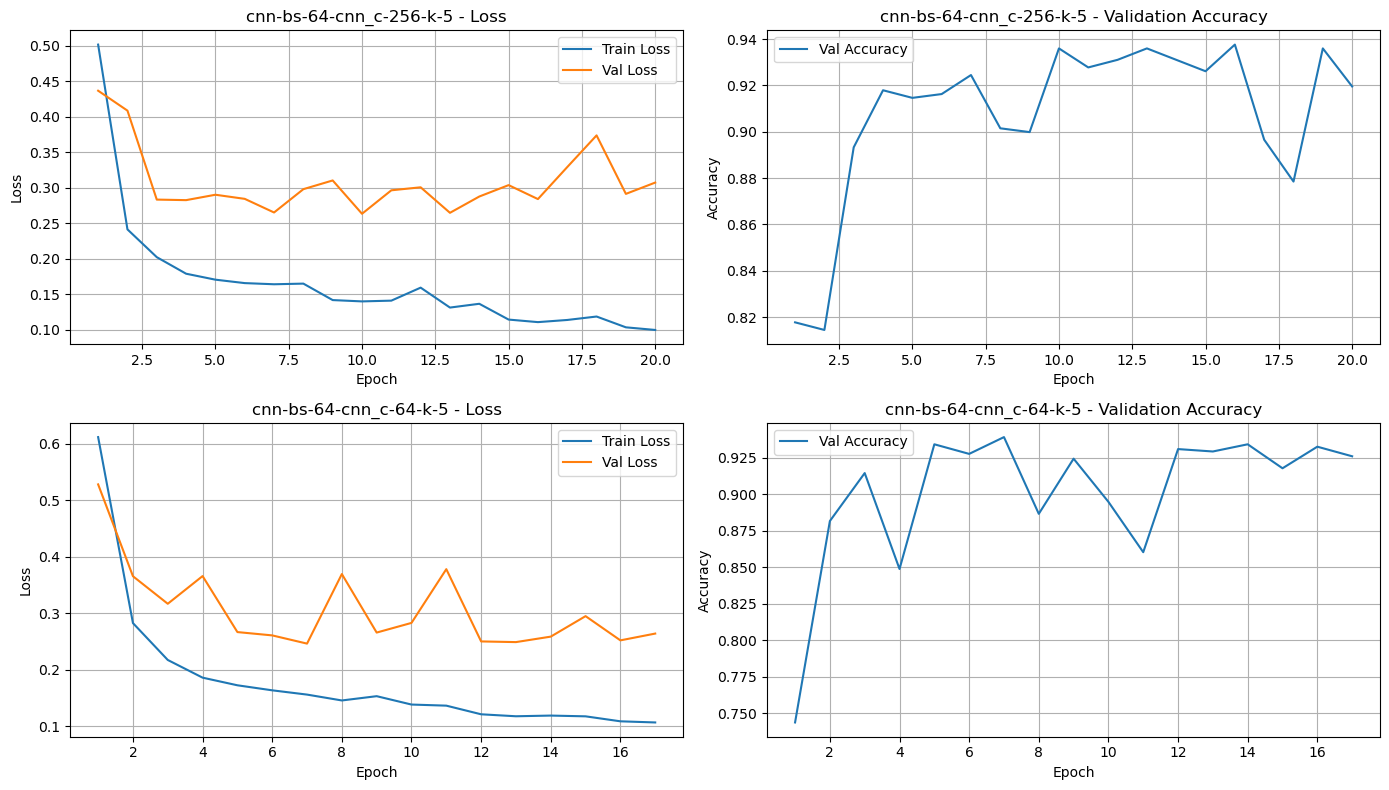

In [5]:
utils.plot_model_metrics(models_to_plot, all_data, max_models=2)

Resultate immernoch nicht zufrieden stellend. Passen wir das CNN Modell an sich selber noch an und fahren wir aber weiter mit den Hyperparametern des besten abgeschnittenen model.

## Unsere verbesste Modellarchitektur
 
```python
    class ImprovedCNN(nn.Module):
        def __init__(self, in_channels, num_classes, hidden_channels=64, kernel_size=5):
            super().__init__()
            self.conv_block1 = nn.Sequential(
                nn.Conv1d(in_channels, hidden_channels, kernel_size=kernel_size, padding=kernel_size // 2),
                nn.BatchNorm1d(hidden_channels),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2)
            )
            self.conv_block2 = nn.Sequential(
                nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=kernel_size, padding=kernel_size // 2),
                nn.BatchNorm1d(hidden_channels * 2),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(1)
            )
            self.dropout = nn.Dropout(0.3)
            self.fc = nn.Linear(hidden_channels * 2, num_classes)

        def forward(self, x):
            x = self.conv_block1(x)
            x = self.conv_block2(x).squeeze(-1)
            x = self.dropout(x)
            x = self.fc(x)
            return x
```

In [6]:
improved_logs_dir = log_dir / "improved_cnn"

json_files = list(improved_logs_dir.glob("improvedcnn*.json"))

print(f"--------------------------------")
print(f"Anzahl verbesserte CNN runs getestet: {len(json_files)}")
print(f"--------------------------------")

results = []
all_data = {}
for file in json_files:
    with open(file, "r") as f:
        data = json.load(f)
        run_name = file.stem
        results.append({
            "run_name": run_name,
            "val_acc_last": round(data["val_acc"][-1], 3) if data["val_acc"] else None,
            "val_loss_last": round(data["val_loss"][-1], 3) if data["val_loss"] else None,
            "train_loss_last": round(data["train_loss"][-1], 3) if data["train_loss"] else None,
            "test_accuracy": round(data.get("test_metrics", {}).get("test_accuracy", None), 3) if data.get("test_metrics", {}).get("test_accuracy", None) is not None else None,
            "test_f1": round(data.get("test_metrics", {}).get("test_f1", None), 3) if data.get("test_metrics", {}).get("test_f1", None) is not None else None,
        })
        all_data[run_name] = data

df = pd.DataFrame(results)

# Only top 6 models by test_f1
top_n = 6
top_models = df.sort_values(by="test_f1", ascending=False).head(top_n)
worst_models = df.sort_values(by="test_f1", ascending=False).tail(3)

print(f"Top {top_n} Modelle basierend auf Test-F1:")
print(top_models.to_string(index=False))
print(f"--------------------------------")
print(f"Schlechteste 3 Modelle basierend auf Test-F1:")
print(worst_models.to_string(index=False))
print(f"--------------------------------")

models_to_plot = top_models.reset_index(drop=True)

--------------------------------
Anzahl verbesserte CNN runs getestet: 54
--------------------------------
Top 6 Modelle basierend auf Test-F1:
                                   run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_f1
improvedcnn-bs-32-0.0005-cnn_c-128-k-5_norm         0.995          0.019            0.000            1.0      1.0
improvedcnn-bs-128-0.0005-cnn_c-64-k-5_norm         0.995          0.015            0.003            1.0      1.0
 improvedcnn-bs-32-0.001-cnn_c-128-k-5_norm         0.995          0.015            0.000            1.0      1.0
 improvedcnn-bs-64-0.0005-cnn_c-64-k-3_norm         0.998          0.013            0.002            1.0      1.0
 improvedcnn-bs-64-0.0005-cnn_c-64-k-7_norm         0.993          0.017            0.001            1.0      1.0
improvedcnn-bs-64-0.0005-cnn_c-128-k-7_norm         0.998          0.011            0.000            1.0      1.0
--------------------------------
Schlechteste 3 Modelle ba

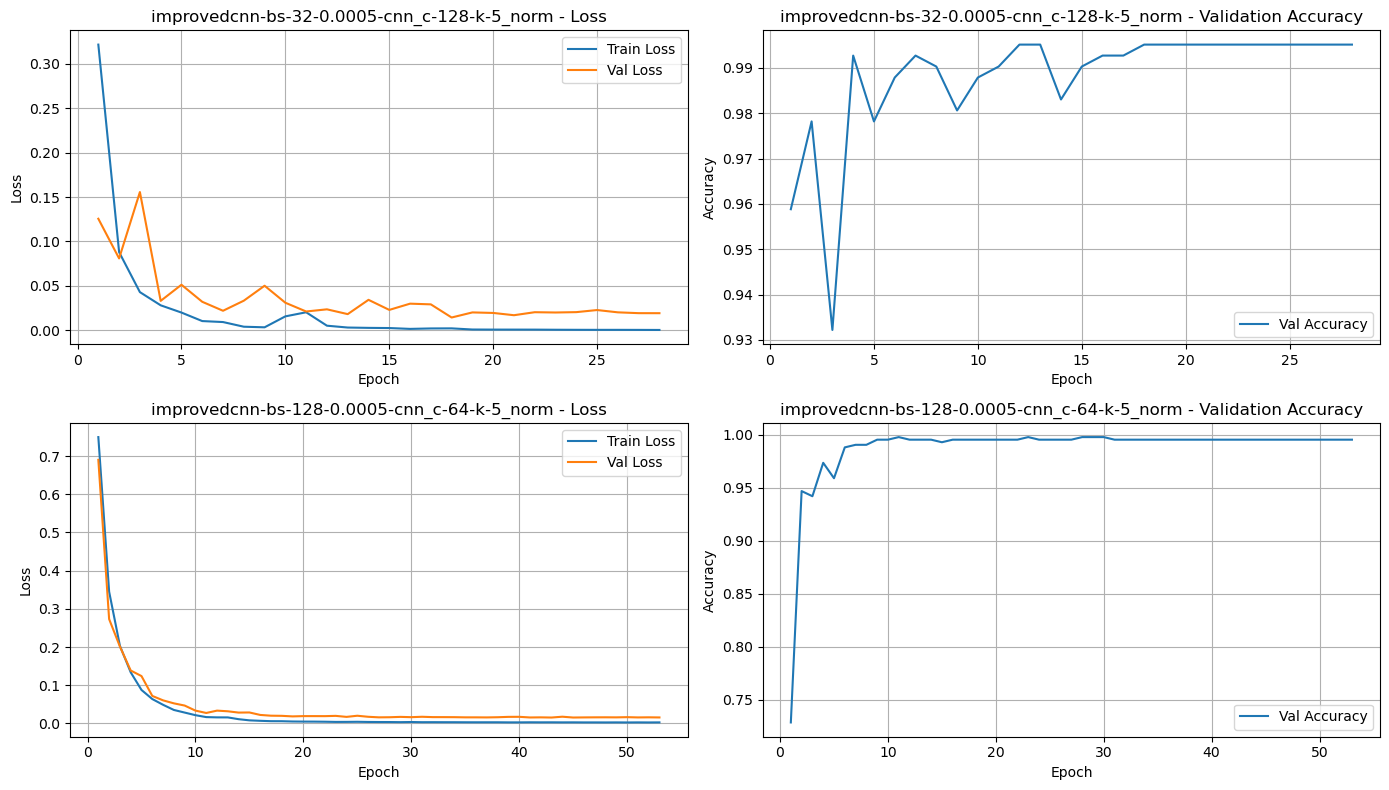

In [7]:
utils.plot_model_metrics(models_to_plot, all_data, max_models=2)

```python
class DeepCNN(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_channels=64, kernel_size=5):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.block3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels * 4, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.shortcut = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels * 4, kernel_size=1),
            nn.AdaptiveAvgPool1d(1)
        )
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_channels * 4, num_classes)

    def forward(self, x):
        residual = self.shortcut(x).squeeze(-1)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x).squeeze(-1)
        x = x + residual  # Residual connection
        x = self.dropout(x)
        x = self.fc(x)
        return x
```

In [8]:
deep_log_dir = log_dir / "deep_cnn"

json_files = list(deep_log_dir.glob("deepcnn*.json"))

print(f"--------------------------------")
print(f"Anzahl tieferer CNN runs getestet: {len(json_files)}")
print(f"--------------------------------")

results = []
all_data = {}
for file in json_files:
    with open(file, "r") as f:
        data = json.load(f)
        run_name = file.stem
        results.append({
            "run_name": run_name,
            "val_acc_last": round(data["val_acc"][-1], 3) if data["val_acc"] else None,
            "val_loss_last": round(data["val_loss"][-1], 3) if data["val_loss"] else None,
            "train_loss_last": round(data["train_loss"][-1], 3) if data["train_loss"] else None,
            "test_accuracy": round(data.get("test_metrics", {}).get("test_accuracy", None), 3) if data.get("test_metrics", {}).get("test_accuracy", None) is not None else None,
            "test_f1": round(data.get("test_metrics", {}).get("test_f1", None), 3) if data.get("test_metrics", {}).get("test_f1", None) is not None else None,
        })
        all_data[run_name] = data

df = pd.DataFrame(results)

# Only top 6 models by test_f1
top_n = 6
top_models = df.sort_values(by="test_f1", ascending=False).head(top_n)
worst_models = df.sort_values(by="test_f1", ascending=False).tail(3)

print(f"Top {top_n} Modelle basierend auf Test-F1:")
print(top_models.to_string(index=False))
print(f"--------------------------------")
print(f"Schlechteste 3 Modelle basierend auf Test-F1:")
print(worst_models.to_string(index=False))
print(f"--------------------------------")

models_to_plot = top_models.reset_index(drop=True)

--------------------------------
Anzahl tieferer CNN runs getestet: 54
--------------------------------
Top 6 Modelle basierend auf Test-F1:
                                run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_f1
 deepcnn-bs-64-0.0001-cnn_c-128-k-5_norm         0.998          0.004            0.000            1.0      1.0
deepcnn-bs-128-0.0001-cnn_c-128-k-3_norm         1.000          0.008            0.001            1.0      1.0
  deepcnn-bs-128-0.001-cnn_c-64-k-5_norm         0.995          0.014            0.000            1.0      1.0
deepcnn-bs-128-0.0001-cnn_c-128-k-7_norm         0.995          0.010            0.001            1.0      1.0
  deepcnn-bs-32-0.0001-cnn_c-64-k-3_norm         0.995          0.010            0.001            1.0      1.0
 deepcnn-bs-128-0.0001-cnn_c-64-k-3_norm         0.995          0.016            0.003            1.0      1.0
--------------------------------
Schlechteste 3 Modelle basierend auf Test-F1:
   

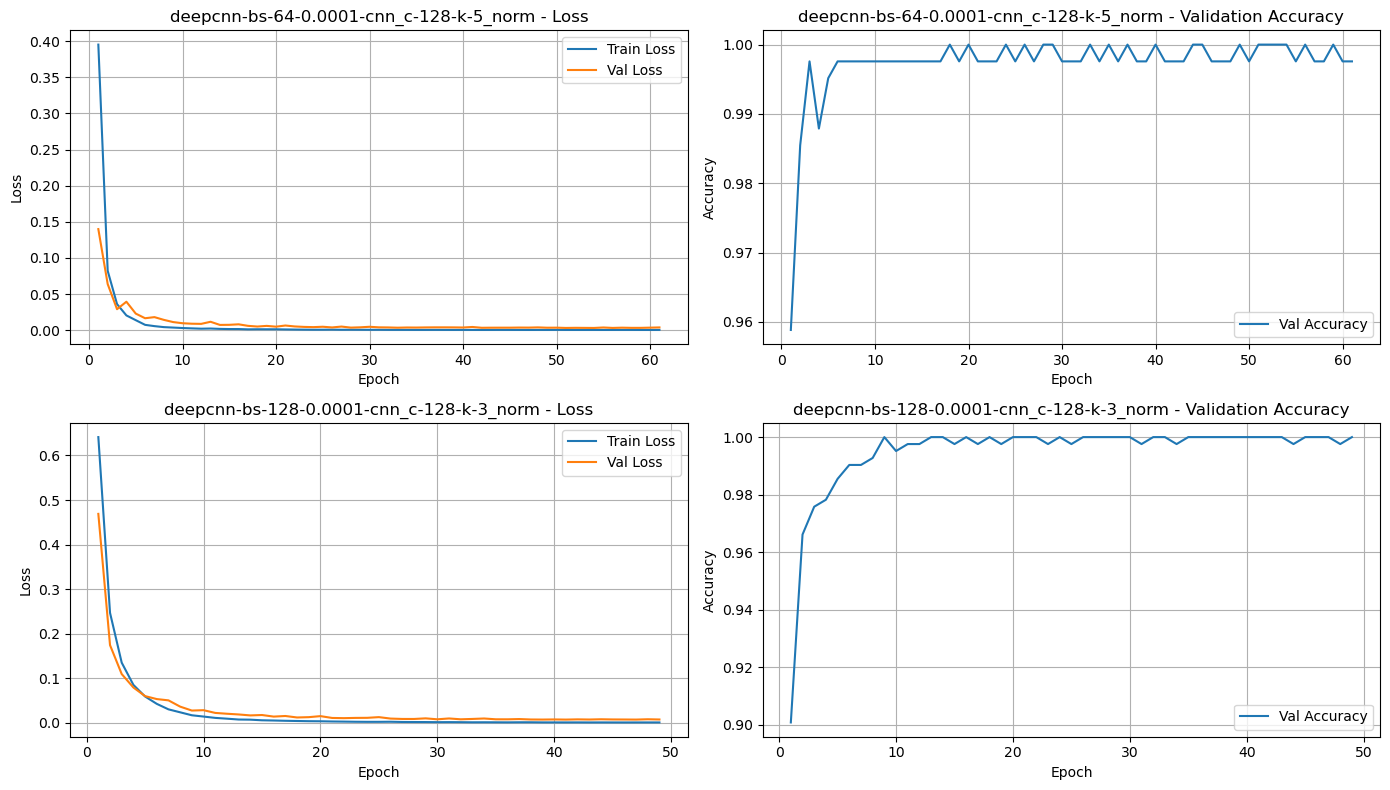

In [9]:
utils.plot_model_metrics(models_to_plot, all_data, max_models=2)

In [ ]:
def print_top3_f1_from_dir(log_dir, dir_name):
    json_files = list(log_dir.glob("*.json"))
    results = []
    for file in json_files:
        with open(file, "r") as f:
            data = json.load(f)
            test_f1 = data.get("test_metrics", {}).get("test_f1", None)
            results.append({
                "run_name": file.stem,
                "test_f1": test_f1
            })
    df = pd.DataFrame(results)
    df = df.dropna(subset=["test_f1"])
    top3 = df.sort_values(by="test_f1", ascending=False).head(3)
    print(f"Top 3 F1 scores in {dir_name}:")
    if not top3.empty:
        print(top3[["run_name", "test_f1"]].to_string(index=False))
    else:
        print("No valid runs found.")
    print("-" * 40)


print_top3_f1_from_dir(cnn_dir, "CNN")
print_top3_f1_from_dir(improved_logs_dir, "ImprovedCNN")
print_top3_f1_from_dir(deep_log_dir, "DeepCNN")


# LSTM 

kurze erklärung

In [ ]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

log_dir = Path("../logs/lstm")

# Just read all json files in the directory (no need to search for a pattern)
json_files = list(log_dir.glob("*.json"))

print(f"--------------------------------")
print(f"Anzahl LSTM runs getestet: {len(json_files)}")
print(f"--------------------------------")

results = []
all_data = {}
for file in json_files:
    with open(file, "r") as f:
        data = json.load(f)
        run_name = file.stem
        final_epoch = -1 if not data["epoch"] else data["epoch"][-1]
        results.append({
            "run_name": run_name,
            "val_acc_last": data["val_acc"][-1] if data["val_acc"] else None,
            "val_loss_last": data["val_loss"][-1] if data["val_loss"] else None,
            "train_loss_last": data["train_loss"][-1] if data["train_loss"] else None,
            "test_accuracy": data.get("test_metrics", {}).get("test_accuracy", None),
            "test_f1": data.get("test_metrics", {}).get("test_f1", None),
            "final_epoch": final_epoch
        })
        all_data[run_name] = data

df = pd.DataFrame(results)

# Only top 6 models by test_f1
top_n = 6
top_models = df.sort_values(by="test_f1", ascending=False).head(top_n)
worst_models = df.sort_values(by="test_f1", ascending=False).tail(3)

print(f"Top {top_n} Modelle basierend auf Test-F1:")
print(top_models.to_string(index=False))
print(f"--------------------------------")
print(f"Schlechteste 3 Modelle basierend auf Test-F1:")
print(worst_models.to_string(index=False))
print(f"--------------------------------")

models_to_plot = top_models.reset_index(drop=True)

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
axes = axes.flatten()

for i, row in models_to_plot.iterrows():
    run_name = row["run_name"]
    data = all_data[run_name]
    ax = axes[i]
    epochs = data["epoch"]
    ax.plot(epochs, data["train_loss"], label="Train Loss", color="tab:blue", linestyle="--")
    ax.plot(epochs, data["val_loss"], label="Val Loss", color="tab:orange", linestyle="-")
    ax2 = ax.twinx()
    ax2.plot(epochs, data["val_acc"], label="Val Acc", color="tab:green", linestyle=":")
    ax.set_title(f"{run_name}\nTest F1: {row['test_f1']:.3f}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax2.set_ylabel("Val Acc")
    if i == 0:
        ax.legend(loc="upper left")
        ax2.legend(loc="upper right")
    ax.grid(True)

# Hide unused subplots if any
for j in range(len(models_to_plot), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# MLP